# Multimodal Analyses between RNA, Metadata, and Metabolite Datasets
**Goal 1:** Identify correlations between RNA and Metabolite across 3 different subsets of genes. 

**Goal 2:** Identify correlation between RNA and Metabolite while controlling for metadata covariates

**Dataset:** Metabolite Dataset, Normalized RNA Dataset, Metadata from the CCLE

**Interest:** Information Overlap between RNA and Metabolite, RNA and Metabolite while controlling for covariates

**Import necessary packages**

In [1]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})

**Read in model (stored in IPython kernel memory)**

In [2]:
store -r model

**Read in model (from file)**

In [3]:
import cobra
from cobra.io import load_matlab_model
model = load_matlab_model("../Models/GEM_Recon2_thermocurated_redHUMAN.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
This model seems to have metHMDB instead of metHMDBID field. Will use metHMDB for what metHMDBID represents.
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, x


KeyboardInterrupt: 

**Use ./general_functions.ipynb to define necessary functions**

In [3]:
%run "./general_functions.ipynb"

**Rename genes in metabolic model based on Entrez to Gene Name(Hugo Symbol) conversion file**

In [4]:
conversion = pd.read_csv("../Data/entrez2protein.csv")
conversion.index = conversion["Entrez ID"]
for gene in model.genes:
    entrez_id = gene.id
    entrez_id = entrez_id.split(".")[0]
    if entrez_id.isnumeric():
        entrez_id = int(entrez_id)
        if entrez_id in list(conversion.index):
            gene_id = conversion.loc[entrez_id]["Gene Name"]
            gene.name = gene_id
        
        else:
            print("Entrez not in file")

**Import RNA and metabolite data files after processed**

(./RNA_processing_in_R.ipynb, ./Metabolite_Preprocessing.ipynb)

In [5]:
cancer_codes = ["BRCA2","CCRCC1","CCRCC2","CCRCC3","CCRCC4","DLBCL","GBM","HurthleCC"]
normalizations = ["logCPMS", "logQUANT","VST", "logTC"]
all_pvalues = {}
all_mean_diffs = {}
for norm in normalizations:
    for cancer in cancer_codes:
        rData = pd.read_csv("../Data/Generated Data/Tumor Generated/Tumor Normalized RNA/%s_RNAseq_genes_counts.%s.normalized.csv"%(cancer,norm), engine = "c", index_col = 0)
        mData = pd.read_csv("../Data/Generated Data/Tumor Generated/processed_%s_metabolite_data.csv"%cancer, engine ="c")
        rData.columns = [x.replace(".","-") for x in rData.columns]
        #rData.columns = [x[1:] for x in rData.columns]
        mData = mData.transpose()
        mData.columns = [str(x) for x in mData.columns]
        rData.columns = [str(x) for x in rData.columns]
        for k in [0,1]:
            cell_lines = list(set(rData.columns).intersection(set(mData.columns)))
            rna_df = rData[cell_lines]
            metabolite_df = mData[cell_lines]
            rna_df = rna_df.loc[:,~rna_df.columns.duplicated()]
            original_rna_df = rna_df.copy()
            metabolite_df = metabolite_df.loc[:,~metabolite_df.columns.duplicated()]
            original_metabolite_df = metabolite_df.copy()
            rna_index = list(rna_df.index)
            metabolite_index = list(metabolite_df.index)
            new_rna_index = subsetting(k, rna_index, metabolite_index, model)
            new_rna_index = [x for x in new_rna_index if type(x) == str]
            rna_df = rna_df[~rna_df.index.duplicated(keep='first')]
            metabolite_names = []
            for met in model.metabolites:
                met_id = "_".join(met.id.split("_")[:-1])
                if met_id not in metabolite_names and met_id in metabolite_index:
                    metabolite_names.append(met_id)
            rna_list = new_rna_index
            metabolite_list = metabolite_names
            rna_df = rna_df.loc[rna_list]
            metabolite_df = metabolite_df.loc[metabolite_list]
            rna_df = averageDuplicates(rna_df)
            overlap = calcOverlap(rna_df, metabolite_df, "DC")
            samplingData = geneSampling(original_rna_df, original_metabolite_df, new_rna_index, 51, "DC")
            samplingData["Original"] = overlap
            samplingData = samplingData.copy()
            all_pvalues["%s, %s, %i"%(cancer, norm, k)] = (stats.ttest_1samp(list(samplingData["Coeffs"]), popmean= overlap)).pvalue
            all_mean_diffs["%s, %s, %i"%(cancer, norm, k)] = overlap - samplingData.Coeffs.mean()

/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap


75


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

83


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

87


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

86


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

105


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

85


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

17


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

82


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

75


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

83


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

87


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

86


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

105


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

85


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

17


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

82


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

75


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

83


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

87


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

86


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

105


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

85


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

17


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

82


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

75


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

83


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

87


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

86


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

105


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

85


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

17


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

82


/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_42030/1776565469.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap


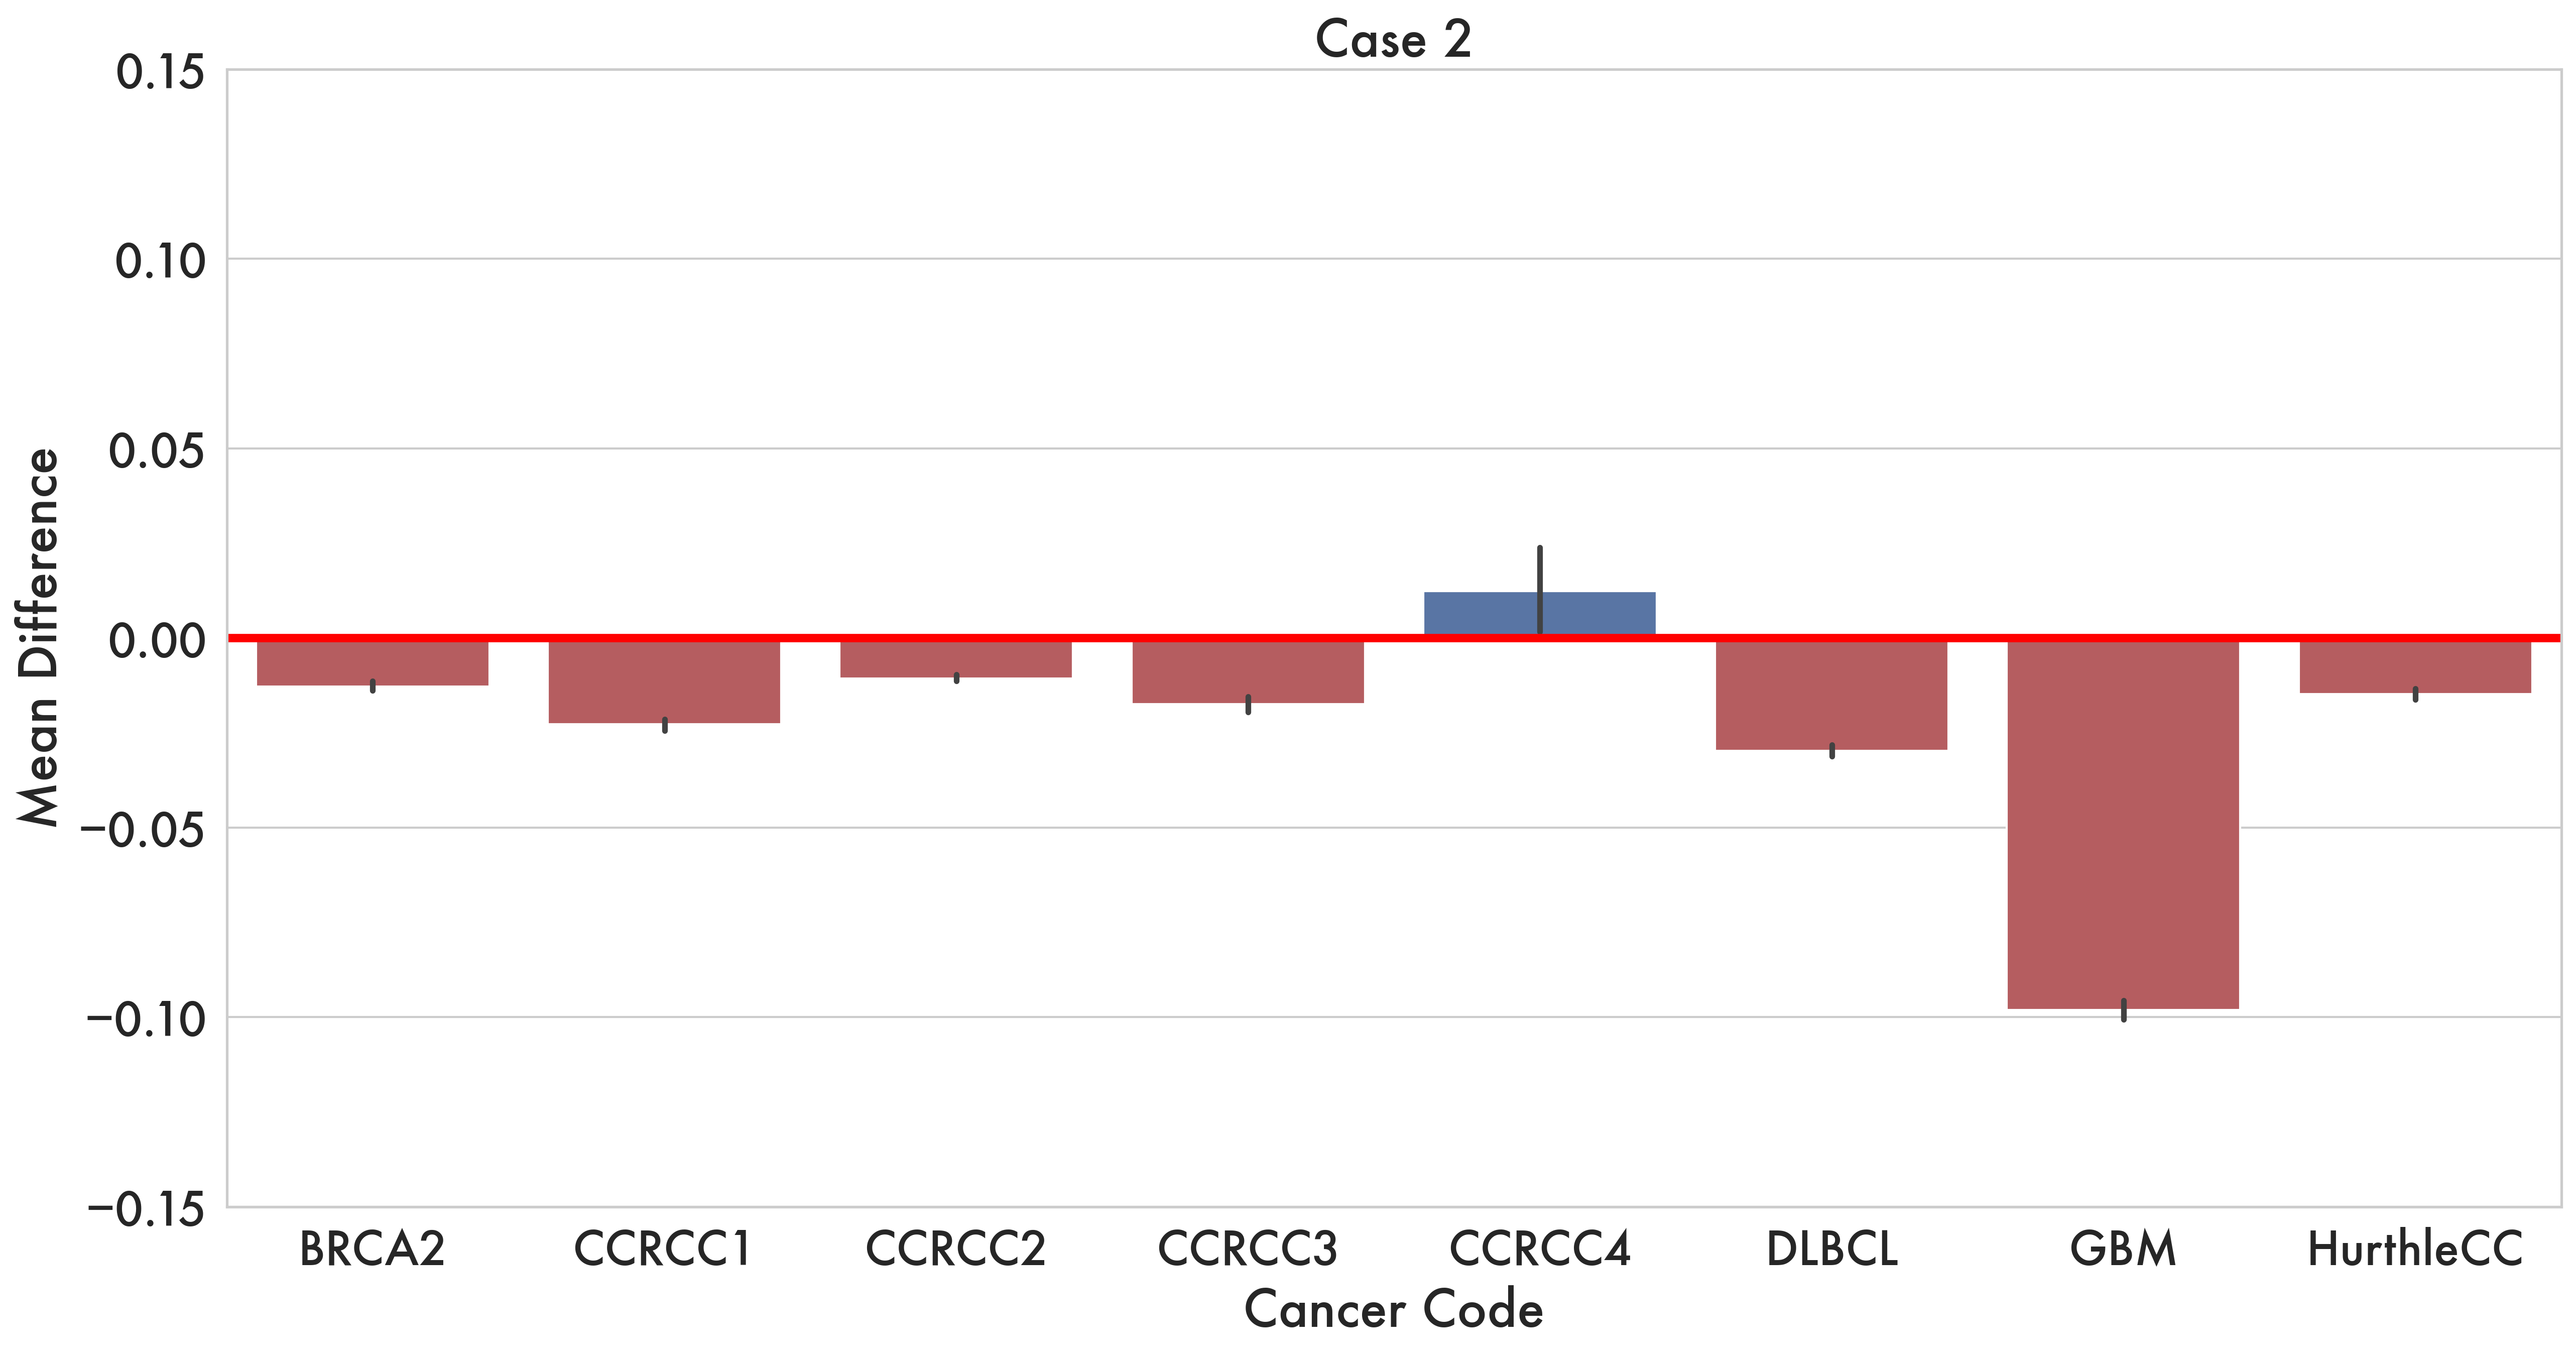

In [7]:
sns.set_theme(font_scale = 2, style = "whitegrid", rc={'figure.figsize':(20,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
np.random.seed(100)
mean_diff_df = pd.read_excel("/Users/tcong/Downloads/necessary_stats_tumor.xlsx", index_col = "Unnamed: 0")
mean_diff_df_0 = mean_diff_df[mean_diff_df["k case"] == 0]
mean_diff_df_1 = mean_diff_df[mean_diff_df["k case"] == 1]
colors = ['b' if c >= 0 else 'r' for c in mean_diff_df_0["Mean Difference"]]
bar = sns.barplot(mean_diff_df_0, y = "Mean Difference", x = "Cancer Code", palette = colors)
bar.set(title = "Case 2", ylim = (-.15,.15))
bar.axhline(y=0, color = "red", linewidth=4)

In [ ]:
cancer_code = "ccRCC3"
rData = pd.read_csv("../Data/Generated Data/Tumor Generated/Tumor Normalized RNA/%s_RNAseq_genes_counts.VST.normalized.csv"% cancer_code, engine = "c", index_col = 0)
mData = pd.read_csv("../Data/Generated Data/Tumor Generated/processed_%s_metabolite_data.csv"%cancer_code, engine ="c")
rData.columns = [x.replace(".","-") for x in rData.columns]
#rData.columns = [x[1:] for x in rData.columns]
mData = mData.transpose()
mData.columns = [str(x) for x in mData.columns]
rData.columns = [str(x) for x in rData.columns]

**Restrict data to cell lines with measurements across protein & metabolites and process duplictes**

In [7]:
cell_lines = list(set(rData.columns).intersection(set(mData.columns)))
rna_df = rData[cell_lines]
metabolite_df = mData[cell_lines]
rna_df = rna_df.loc[:,~rna_df.columns.duplicated()]
original_rna_df = rna_df.copy()
metabolite_df = metabolite_df.loc[:,~metabolite_df.columns.duplicated()]
original_metabolite_df = metabolite_df.copy()

**Set k-case and get indices for both RNA and metabolite data**

In [8]:
rna_index = list(rna_df.index)
metabolite_index = list(metabolite_df.index)
k = 1

**Perform subsetting operation using k-case and get new subset of genes**

In [9]:
new_rna_index = subsetting(k, rna_index, metabolite_index, model)
new_rna_index = [x for x in new_rna_index if type(x) == str]

86


**Check number of genes**

In [10]:
len(new_rna_index)

603

**Remove duplicate genes**

In [11]:
rna_df = rna_df[~rna_df.index.duplicated(keep='first')]

**Remove cellular compartment suffixes from metabolites in model**

In [12]:
metabolite_names = []
for met in model.metabolites:
    met_id = "_".join(met.id.split("_")[:-1])
    if met_id not in metabolite_names and met_id in metabolite_index:
        metabolite_names.append(met_id)

**Subset to new gene subset and metabolite subset**

In [13]:
rna_list = new_rna_index
metabolite_list = metabolite_names
rna_df = rna_df.loc[rna_list]
metabolite_df = metabolite_df.loc[metabolite_list]

**Average duplicates (if any)**

In [14]:
rna_df = averageDuplicates(rna_df)

**Calculate the information overlap between RNA and metabolite after subsetting using k**

In [15]:
%%time
overlap = calcOverlap(rna_df, metabolite_df, "DC")
print("DC coeff is: %f" %overlap)

DC coeff is: 0.760409
CPU times: user 9.22 ms, sys: 2.64 ms, total: 11.9 ms
Wall time: 7.83 ms



**Get information overlap for permutations and graph distribution**

**Also: perform one-sample T-test between permuted overlaps and true overlap**

T-test: TtestResult(statistic=-131.32162114398528, pvalue=4.32869622549615e-64, df=49)
CPU times: user 147 ms, sys: 76.2 ms, total: 223 ms
Wall time: 149 ms


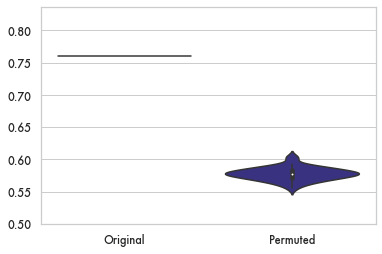

In [16]:
%%time
permutationData = permuteDataframe(rna_df, metabolite_df, 51, "DC")
permutationData["Original"] = overlap
permutationData["Permuted"] = permutationData[0]
permutationData = permutationData.drop(0, axis = 1)
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
fig1 = sns.violinplot(data = permutationData, color = "#2F258D")
fig1.set_ylim(permutationData.Permuted.min()*.9, overlap*1.1);
print("T-test: " + str(stats.ttest_1samp(list(permutationData["Permuted"]), popmean= overlap)))

**Perform gene sampling and graph distribution of information overlap**

**Also: perform one-sample T-test between sampled overlaps and true overlap**

/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_5820/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_5820/2429060530.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] = overlap


T-test: TtestResult(statistic=24.844949434765997, pvalue=1.999350208346633e-29, df=49)


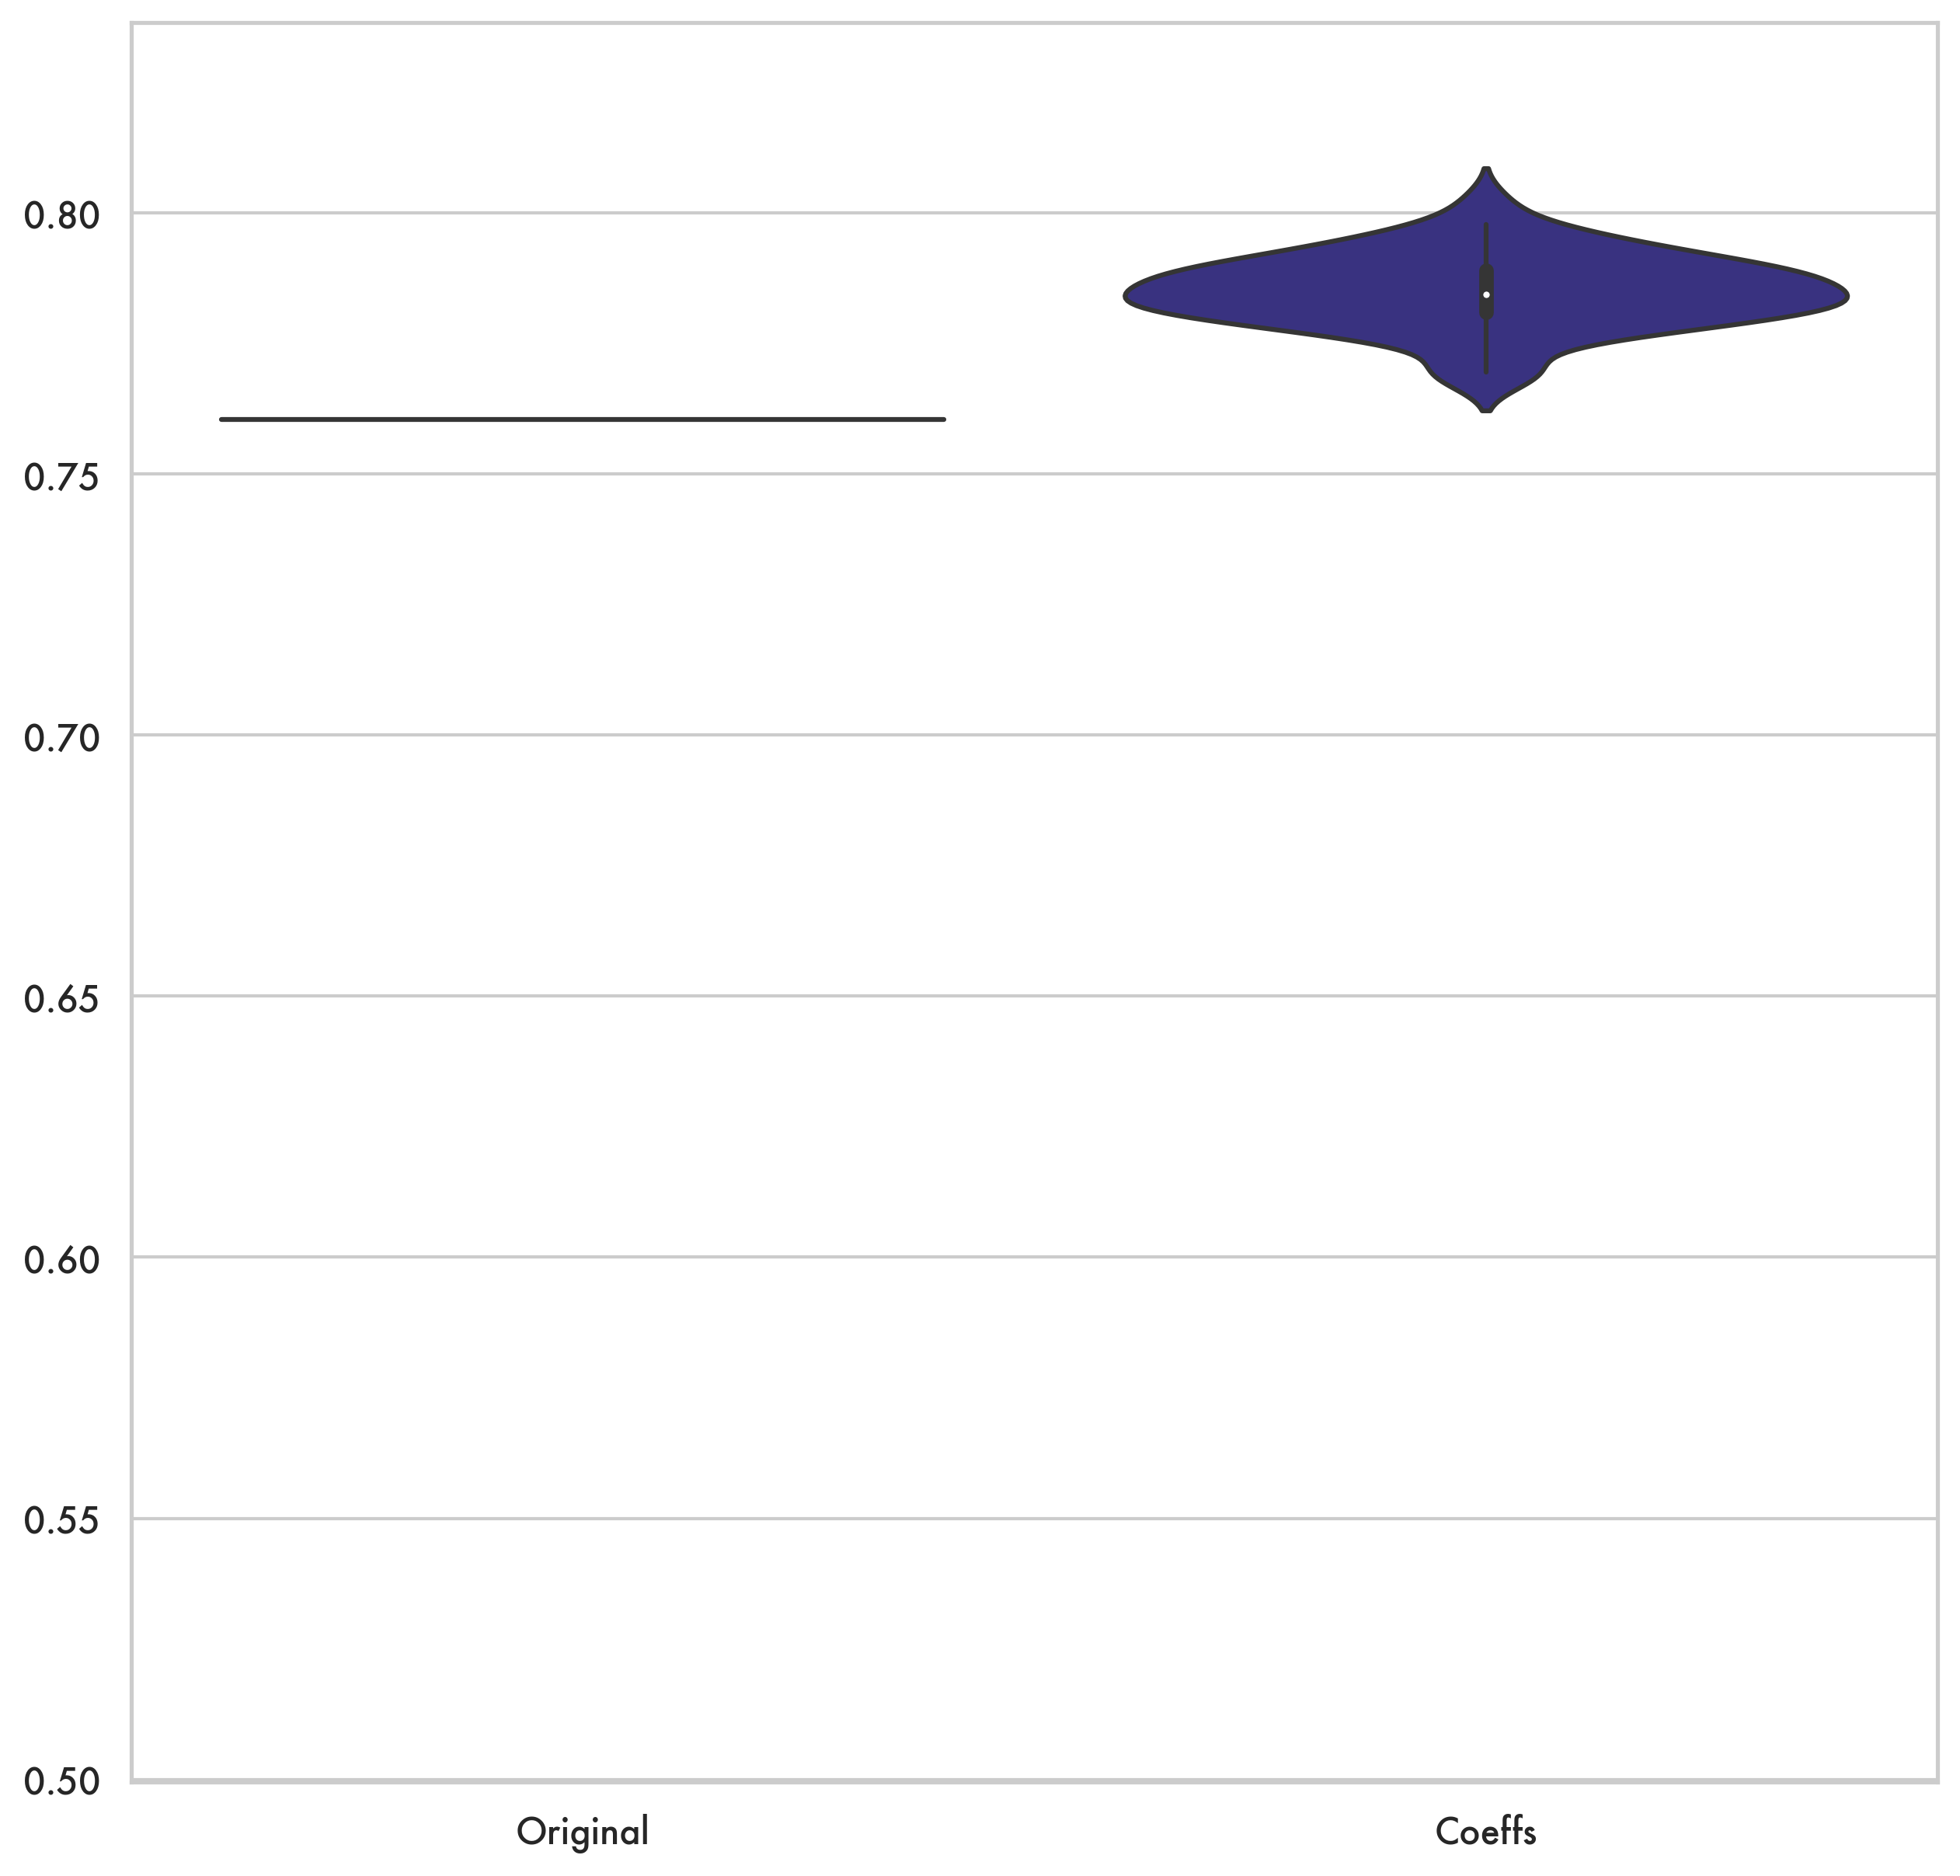

In [17]:
samplingData = geneSampling(original_rna_df, original_metabolite_df, new_rna_index, 51, "DC")
samplingData["Original"] = overlap
samplingData = samplingData.copy()
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
fig2 = sns.violinplot(data = samplingData, order = ["Original", "Coeffs"], color = "#2F258D")
fig2.set_ylim(permutationData.Permuted.min()*.9, overlap*1.1);
print("T-test: " + str(stats.ttest_1samp(list(samplingData["Coeffs"]), popmean= overlap)))

In [ ]:
%%time
permutationData = permuteDataframe(rna_df, metabolite_df, 50, "DC")


In [ ]:
reaction_df = pd.DataFrame()
list_of_df = [reaction_df]
for x in rna_df.columns:
    cell_line_dict = makeCellReactionDict(model,x)
    cell_line_df = pd.DataFrame().from_dict(cell_line_dict,orient= "index")
    list_of_df.append(cell_line_df)
reaction_df = pd.concat(list_of_df, axis = 1)
reaction_df.columns = rna_df.columns

In [5]:
meta_data = pd.read_csv("../Data/Tumour Data/TUMOR.NECROSIS.csv", index_col = "Unnamed: 0")

In [7]:
meta_data.index = [x.replace(".","-") for x in meta_data.index]

**Calculate PDC/true overlap for numerical covariates**

In [33]:
cancer_codes = ["CCRCC3","CCRCC4"]
normalizations = ["logCPMS", "logQUANT","VST", "logTC"]
all_pdc_mean_diffs = {}
from statistics import mean
list_of_true_pdc_ratio = []
for norm in normalizations:
    for cancer in cancer_codes:
        meta_data = pd.read_csv("../Data/Tumour Data/TUMOR.PURITY.csv", index_col = "Unnamed: 0")
        meta_data.index = [x.replace(".","-") for x in meta_data.index]
        meta_data = meta_data.transpose()
        rData = pd.read_csv("../Data/Generated Data/Tumor Generated/Tumor Normalized RNA/%s_RNAseq_genes_counts.%s.normalized.csv"%(cancer,norm), engine = "c", index_col = 0)
        mData = pd.read_csv("../Data/Generated Data/Tumor Generated/processed_%s_metabolite_data.csv"%cancer, engine ="c")
        rData.columns = [x.replace(".","-") for x in rData.columns]
        necrosis_samples = 'MSKC-00593', 'MSKC-00627','MSKC-00362', 'MSKC-00334', 'MSKC-00333', 'MSKC-00365'
        mData = mData[~mData.index.isin(necrosis_samples)]
        #rData.columns = [x[1:] for x in rData.columns]
        mData = mData.transpose()
        mData.columns = [str(x) for x in mData.columns]
        rData.columns = [str(x) for x in rData.columns]
        for k in [0,1]:
            cell_lines = list(set(rData.columns).intersection(set(mData.columns)))
            rna_df = rData[cell_lines]
            metabolite_df = mData[cell_lines]
            rna_df = rna_df.loc[:,~rna_df.columns.duplicated()]
            original_rna_df = rna_df.copy()
            metabolite_df = metabolite_df.loc[:,~metabolite_df.columns.duplicated()]
            original_metabolite_df = metabolite_df.copy()
            rna_index = list(rna_df.index)
            metabolite_index = list(metabolite_df.index)
            new_rna_index = subsetting(k, rna_index, metabolite_index, model)
            new_rna_index = [x for x in new_rna_index if type(x) == str]
            rna_df = rna_df[~rna_df.index.duplicated(keep='first')]
            metabolite_names = []
            for met in model.metabolites:
                met_id = "_".join(met.id.split("_")[:-1])
                if met_id not in metabolite_names and met_id in metabolite_index:
                    metabolite_names.append(met_id)
            rna_list = new_rna_index
            metabolite_list = metabolite_names
            rna_df = rna_df.loc[rna_list]
            metabolite_df = metabolite_df.loc[metabolite_list]
            rna_df = averageDuplicates(rna_df)
            
            shared_samples = list(set(meta_data.columns).intersection(set(rna_df.columns)))
            meta_data_analysis = meta_data[shared_samples]
            rna_df_analysis = rna_df[shared_samples]
            partial = calcPDC(rna_df_analysis.transpose().to_numpy(), metabolite_df[shared_samples].transpose().to_numpy(), meta_data_analysis)
            overlap = calcOverlap(rna_df_analysis, metabolite_df[shared_samples], "DC")
            
            true_pdc_ratio = partial/overlap
            
            samplingData = geneSampling(original_rna_df, original_metabolite_df, new_rna_index, 51, "DC")
            samplingData["Original"] = overlap
            samplingData = samplingData.copy()
            
            gene_frame = samplingData[[x for x in samplingData.columns if type(x) == int]]
            list_of_sample_pdc_ratio = []
            for i in range(0,len(gene_frame)):
                genes = list(gene_frame.iloc[i].values)
                shared_samples = list(set(meta_data.columns).intersection(set(rna_df.columns)))
                meta_data_analysis = meta_data[shared_samples]
                rna_full = rData[cell_lines]
                rna_df_analysis = rna_full[shared_samples]
                rna_df_analysis = rna_df_analysis.loc[genes]
                partial = calcPDC(rna_df_analysis.transpose().to_numpy(), metabolite_df[shared_samples].transpose().to_numpy(), meta_data_analysis)
                overlap = calcOverlap(rna_df_analysis, metabolite_df[shared_samples], "DC")
                list_of_sample_pdc_ratio.append(true_pdc_ratio-(partial/overlap))
            all_pdc_mean_diffs["%s, %s, %i"%(cancer, norm, k)] = mean(list_of_sample_pdc_ratio)
pdc_mean_diff_df = pd.DataFrame.from_dict(all_pdc_mean_diffs, orient = "index", columns = ["pDC Mean Difference"])
pdc_mean_diff_df = pdc_mean_diff_df.reset_index()
pdc_mean_diff_df[["Cancer Code", "Normalization", "k case"]] = pdc_mean_diff_df["index"].str.split(",", expand = True)
pdc_mean_diff_df["k case"] = [eval(x) for x in pdc_mean_diff_df["k case"]]
pdc_mean_diff_df_0 = pdc_mean_diff_df[pdc_mean_diff_df["k case"] == 0]
pdc_mean_diff_df_1 = pdc_mean_diff_df[pdc_mean_diff_df["k case"] == 1]
pdc_mean_diff_df["Cancer Cohort & k case"] = pdc_mean_diff_df["Cancer Code"] + " k=" +pdc_mean_diff_df["k case"].astype(str)

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  t

86


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  t

105


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

86


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

105


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

86


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  t

105


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

86


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  t

105


/Users/tcong/opt/anaconda3/envs/METenv/lib/python3.10/site-packages/dcor/_dcor_internals.py:336: RuntimeWarning: invalid value encountered in double_scalars
  total_u_mean = total_sum / ((dim - 1) * (dim - 2))
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1287252268.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData.insert(0, 'Coeffs', Coeffs)
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/135357945.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  samplingData["Original"] =

In [56]:
pdc_mean_diff_df["Case"] = pdc_mean_diff_df["k case"] + 2
pdc_mean_diff_df["Cancer Cohort & Case"] = pdc_mean_diff_df["Cancer Code"] + ": Case " +pdc_mean_diff_df["Case"].astype(str)

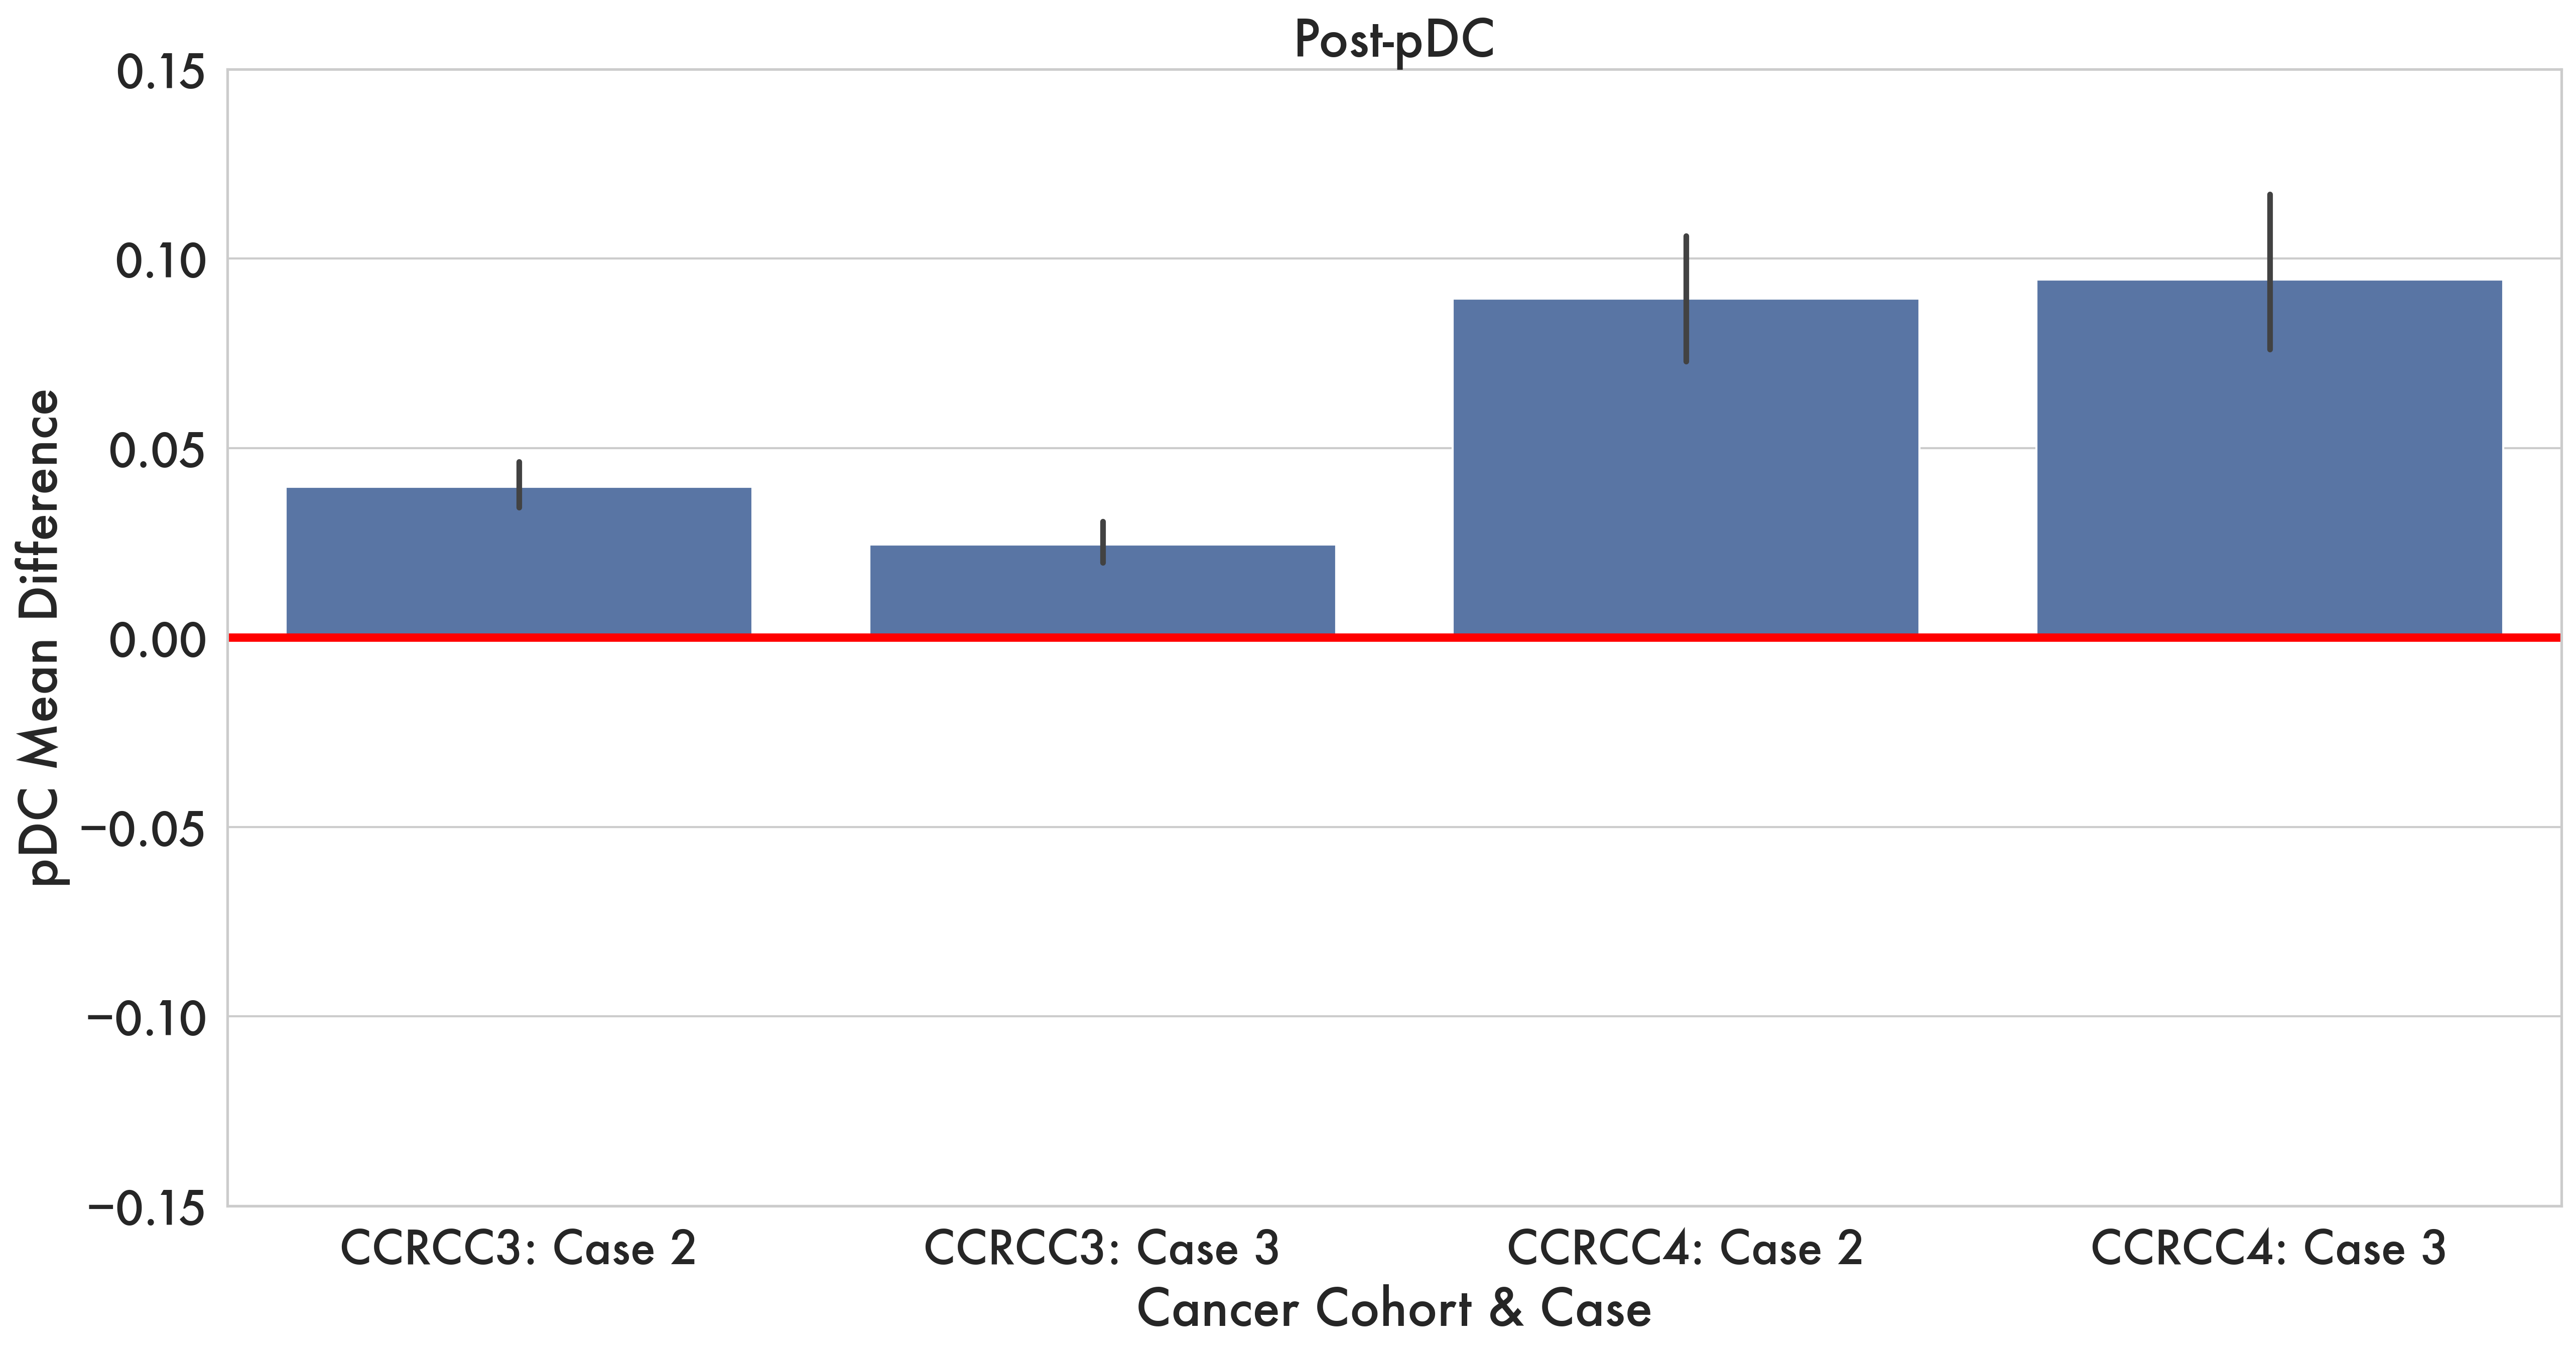

In [57]:
sns.set_theme(style = "whitegrid",font_scale= 2, rc={'figure.figsize':(20,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
colors = ['b' if c >= 0 else 'r' for c in pdc_mean_diff_df["pDC Mean Difference"]]
bar = sns.barplot(pdc_mean_diff_df, y = "pDC Mean Difference", x = "Cancer Cohort & Case", palette = colors)
bar.set(ylim = [-.15,0.15])
bar.set(title = "Post-pDC")
bar.axhline(y=0, color = "red", linewidth=4)

In [58]:
mean_diff_df["Cancer Cohort & k case"] = mean_diff_df["Cancer Code"] + " k=" + mean_diff_df["k case"].astype(str)
mean_diff_ccRCC_df = mean_diff_df[mean_diff_df["Cancer Code"].isin(["CCRCC3","CCRCC4"])]
mean_diff_ccRCC_df["Case"] = mean_diff_ccRCC_df["k case"] + 2
mean_diff_ccRCC_df["Cancer Cohort & Case"] = mean_diff_ccRCC_df["Cancer Code"] + ": Case " +mean_diff_ccRCC_df["Case"].astype(str)

/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1145923597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_diff_ccRCC_df["Case"] = mean_diff_ccRCC_df["k case"] + 2
/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_82199/1145923597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_diff_ccRCC_df["Cancer Cohort & Case"] = mean_diff_ccRCC_df["Cancer Code"] + ": Case " +mean_diff_ccRCC_df["Case"].astype(str)


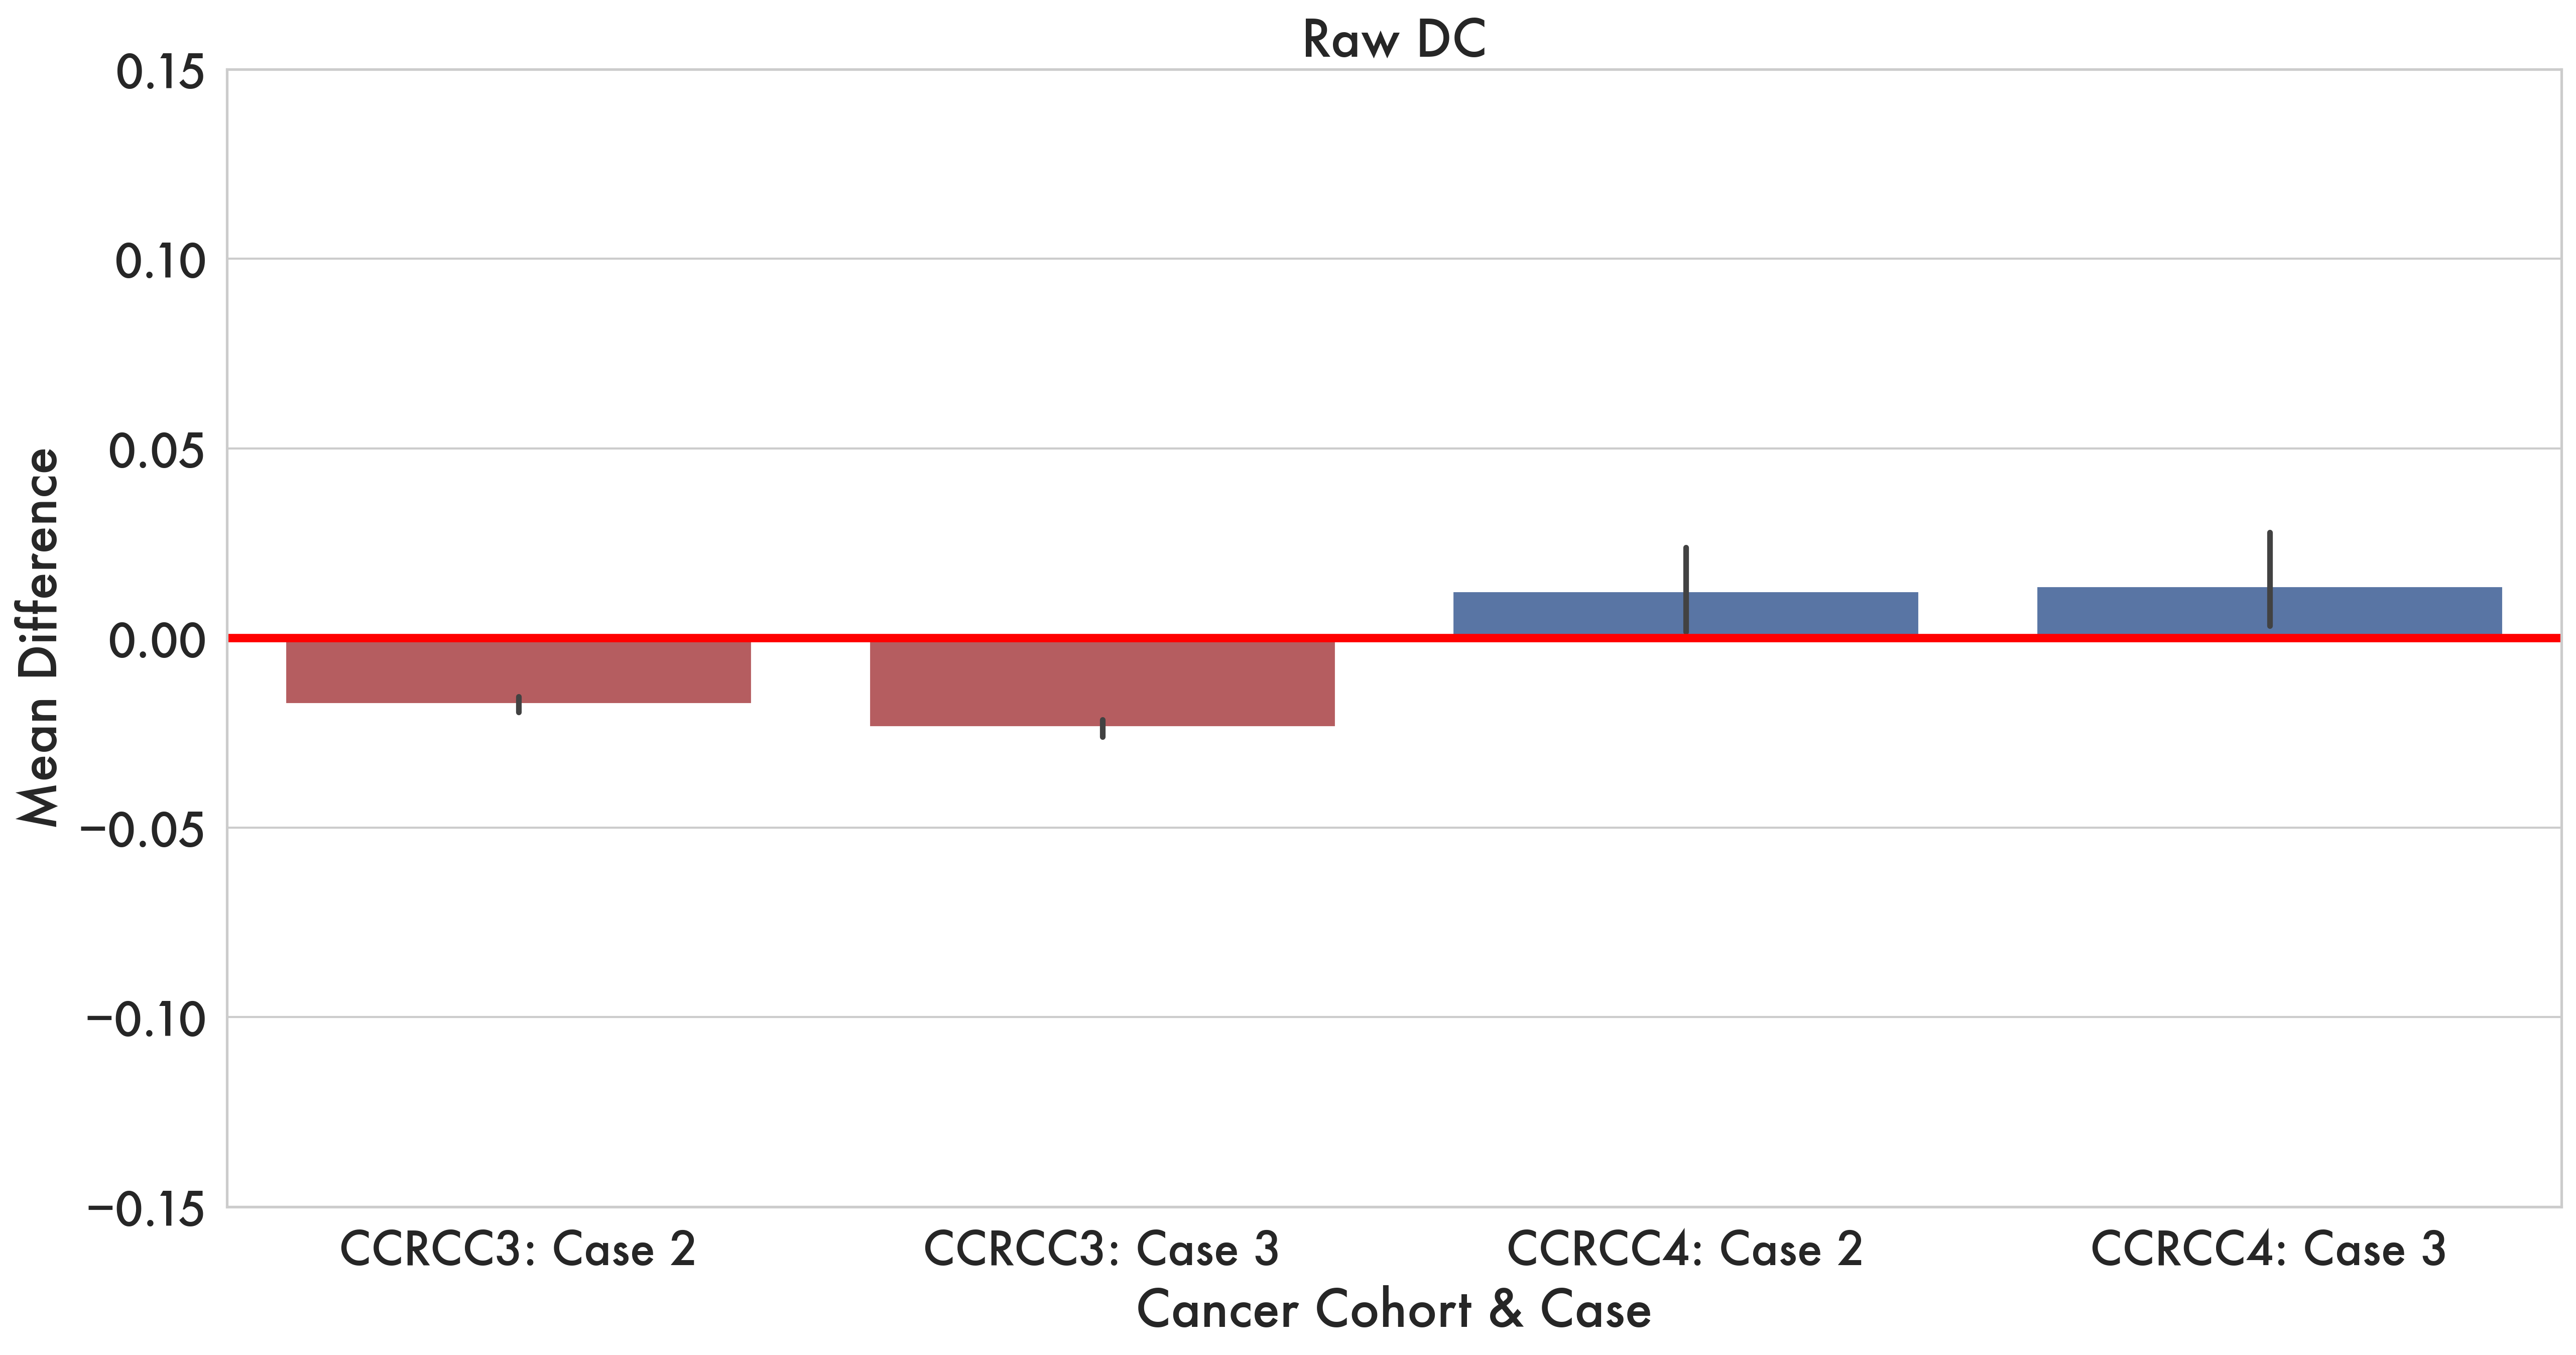

In [60]:
sns.set_theme(style = "whitegrid",font_scale= 2, rc={'figure.figsize':(20,10),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
colors = ['b' if c >= 0 else 'r' for c in mean_diff_ccRCC_df["Mean Difference"]]
bar = sns.barplot(mean_diff_ccRCC_df, y = "Mean Difference", x = "Cancer Cohort & Case", palette = colors)
bar.set(ylim = [-.15,0.15])
bar.set(title = "Raw DC")
bar.axhline(y=0, color = "red", linewidth=4)

**Plot distribution of these difference between true overlap and PDC across covariates**

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
sns.set(font_scale=.5)
g = sns.heatmap(list_of_PDC, cmap = "crest",fmt = "f", annot = True)
g.set(ylabel = "Covariates")
ax = g
ax.add_patch(Rectangle((0, 0), 1, 2, fill=False, edgecolor='red', lw=2))
plt.tight_layout()
plt.show()

**Calculate PDC for all covariates at once**

In [ ]:
meta_variables = ["mutRate", "Doubling.Time.Calculated.hrs"] + list(meta_data.iloc[-55:].index)
meta_data_analysis = meta_data.dropna(axis =1,subset = meta_variables)
all_pdc = calcPDC(rna_df[meta_data_analysis.columns].transpose().to_numpy(), 
         metabolite_df[meta_data_analysis.columns].transpose().to_numpy(), meta_data_analysis.loc[meta_variables].transpose().astype(float))
true_dc = calcOverlap(rna_df[meta_data_analysis.columns].transpose(), metabolite_df[meta_data_analysis.columns].transpose(), "DC")
print("PDC/DC with all covariates: %f" %(all_pdc/true_dc ))

In [ ]:
meta_variables = list(meta_data.iloc[-55:].index)

meta_data_analysis = meta_data.dropna(axis =1,subset = meta_variables)
all_pdc = calcPDC(rna_df[meta_data_analysis.columns].transpose().to_numpy(), 
         metabolite_df[meta_data_analysis.columns].transpose().to_numpy(), meta_data_analysis.loc[meta_variables].transpose().astype(float))
true_dc = calcOverlap(rna_df[meta_data_analysis.columns].transpose(), metabolite_df[meta_data_analysis.columns].transpose(), "DC")
print("PDC/DC with media covariates: %f" %(all_pdc/true_dc ))

In [ ]:
rna_df[meta_data_analysis.columns]

In [ ]:
rna_df